<a href="https://colab.research.google.com/github/fernandofsilva/LSTM_Option_Pricing/blob/main/notebooks/02_black_scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title Carregar as bibliotecas bases
import pandas as pd
import numpy as np
import math

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('whitegrid')

Carregando os dados que foram parseados anteriormente

In [2]:
#@title Carregando os dados de cotações da B3 com o periódo de 2015 até 2020.
raw_data = pd.read_csv('/content/drive/My Drive/Mestrado/data/cotacao_historica.csv.gz')
raw_data.head()

,data_pregao,codigo,mercado,preco,preco_exercicio,data_vencimento
0,2019-01-02,AALR3,VISTA,13.25,0.0,2019-01-02
1,2019-01-02,AAPL34,VISTA,60.41,0.0,2019-01-02
2,2019-01-02,ABBV34,VISTA,342.84,0.0,2019-01-02
3,2019-01-02,ABCB4,VISTA,17.12,0.0,2019-01-02
4,2019-01-02,ABEV3,VISTA,16.15,0.0,2019-01-02


# Opções

Selecionada somente os dados de opções de PETR4.

In [3]:
#@title Processamento dos dados de opções
# Filtrar somente dados de opções
option = raw_data[raw_data['mercado'].isin(['OPÇÕES DE VENDA', 'OPÇÕES DE COMPRA'])]
option = option[option['codigo'].str.startswith('PETR')]

option.head()

,data_pregao,codigo,mercado,preco,preco_exercicio,data_vencimento
232812,2019-01-02,PETRG20,OPÇÕES DE COMPRA,8.50,19.29,2020-07-20
232813,2019-01-02,PETRB224,OPÇÕES DE COMPRA,2.94,21.75,2019-02-18
232814,2019-01-02,PETRO299,OPÇÕES DE VENDA,5.50,29.25,2019-03-18
232818,2019-01-02,PETRA191,OPÇÕES DE COMPRA,5.63,18.50,2019-01-21
232819,2019-01-02,PETRC219,OPÇÕES DE COMPRA,3.70,21.25,2019-03-18


A variável T  é dada pelo fração do tempo em formato anual, entre o dia da cotação até o vencimento da opção.

In [4]:
#@title Cálculo da variável T
# Pegar o valor dos dias que não se repetem
workday = pd.DataFrame({'dia': option['data_pregao'].unique()})
workday['dia'] = pd.to_datetime(workday['dia'])
workday = workday.sort_values(by='dia')

# Criar lista T
T = list()

for index, row in option.iterrows():
    T.append(workday[(workday['dia'] >= row.data_pregao) & (workday['dia'] <= row.data_vencimento)].shape[0] - 1)

option['T'] = T
option['T'] = option['T'] / 252

# Formatar os dados de data
option['data_pregao'] = pd.to_datetime(option['data_pregao'])
option['data_vencimento'] = pd.to_datetime(option['data_vencimento'])
option = option.sort_values(by='data_pregao')

# Adicionar index no dataframe
option.index = option['data_pregao']
option = option.drop(['data_pregao'], axis=1)
option = option.rename(columns={'preco': 'preco_opcao'})

option.head()

,codigo,mercado,preco_opcao,preco_exercicio,data_vencimento,T
data_pregao,,,,,,
2015-01-02,PETRM78,OPÇÕES DE VENDA,1.47,10.91,2015-01-19,0.043651
2015-01-02,PETRF14,OPÇÕES DE COMPRA,0.45,14.00,2015-06-15,0.436508
2015-01-02,PETRL44,OPÇÕES DE COMPRA,0.50,17.00,2015-12-21,0.952381
2015-01-02,PETRM1,OPÇÕES DE VENDA,1.34,10.66,2015-01-19,0.043651
2015-01-02,PETRM10,OPÇÕES DE VENDA,0.19,8.61,2015-01-19,0.043651


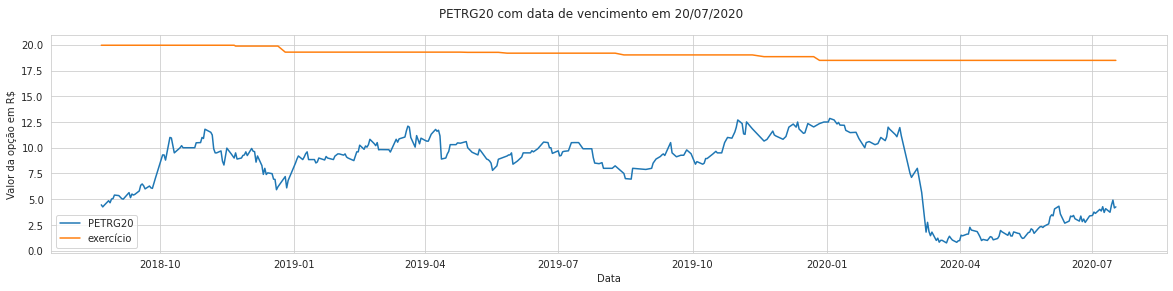

In [5]:
#@title Plot dos dados da opção PETRG20
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('PETRG20 com data de vencimento em 20/07/2020')
ax.plot(option.loc[(option['codigo'] == 'PETRG20') & (option['data_vencimento'] == '2020-07-20'), 'preco_opcao'], label='PETRG20')
ax.plot(option.loc[(option['codigo'] == 'PETRG20') & (option['data_vencimento'] == '2020-07-20'), 'preco_exercicio'], label='exercício')
ax.set_ylabel('Valor da opção em R$')
ax.set_xlabel('Data')
ax.legend()
plt.show()

# Taxa de Juros livre de Risco

Carregar e processar os dados de CDI que foram baixados anteriormente

In [6]:
#@title Formatando os dados
# Carregando os dados
cdi = pd.read_csv('/content/drive/My Drive/Mestrado/data/cdi.csv.gz', compression='gzip')

# Formatando a coluna de data
cdi['data'] = pd.to_datetime(cdi['data'])
cdi = cdi.sort_values(by='data')

# Filtrando o primeiro dia do mês
cdi = cdi[cdi['data'].dt.month != cdi['data'].dt.month.shift(1)]

# Criando um intervalo de datas para referência
date = pd.DataFrame({'data': pd.date_range(start='1/1/2015', end='12/31/2020')})

# Junção com os dados de CDI
date = date.merge(right=cdi, how='left', on='data')

# Preenchendo os vazios
date['taxa_juros'] = date['taxa_juros'].fillna(method='ffill')
date['taxa_juros'] = date['taxa_juros'] / 100
cdi = date.dropna()

# Criando a coluna de indice
cdi.index = cdi['data']
cdi = cdi.drop(['data'], axis=1)
cdi.head()

,taxa_juros
data,
2015-01-02,0.1157
2015-01-03,0.1157
2015-01-04,0.1157
2015-01-05,0.1157
2015-01-06,0.1157


As taxas de juros de cupom cambial do mercado de DDI são, atualmente, obtidas a partir dos primeiros vencimentos dos contratos futuros de DI1 e de Taxa de Câmbio de Reais por Dólar Comercial, onde é obtido o primeiro vencimento sintético de DDI e a partir daí utilizada as cotações da Estratégia Operacional de FRA e de Cupom Cambial para obtenção de vencimentos mais distantes.

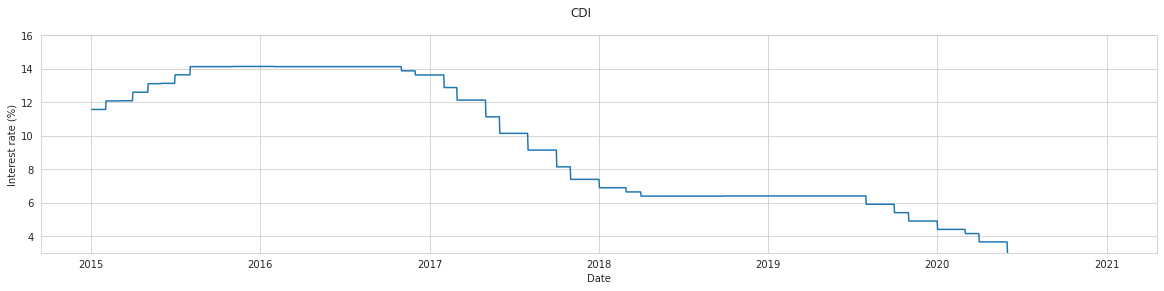

In [7]:
#@title Plot Taxa de Juros livre de Risco (CDI)
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('CDI')
ax.plot(cdi * 100)
ax.set_ylabel('Interest rate (%)')
ax.set_ylim(3, 16)
ax.set_xlabel('Date')
plt.show()

# Volatilidade

Carregar os dados de volatilidade que foram modelados anteriormente.

In [8]:
#@title Carregando os dados de volatilidade
vol = pd.read_csv('/content/drive/My Drive/Mestrado/data/volatilidade_garch.csv.gz')
vol.index = vol['data_pregao']
vol = vol.drop(['data_pregao'], axis=1)
vol.head()

,preco_ativo,volatilidade
data_pregao,,
2015-01-05,8.61,0.771953
2015-01-06,8.33,0.843418
2015-01-07,8.67,0.813362
2015-01-08,9.18,0.791204
2015-01-09,9.40,0.797282


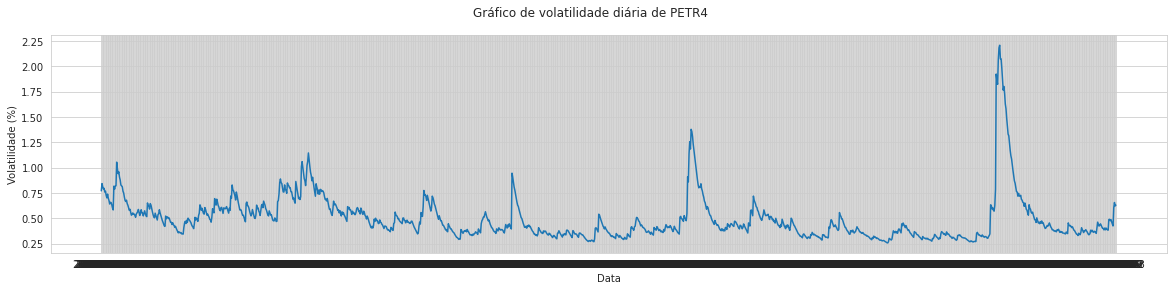

In [9]:
#@title Plot Volatilidade Condicional
fig, axs = plt.subplots(figsize=(20, 4))
fig.suptitle('Gráfico de volatilidade diária de PETR4')
axs.plot(vol['volatilidade'])
axs.set_ylabel('Volatilidade (%)')
axs.set_xlabel('Data')
plt.show()

# Junção dos dados

In [10]:
#@title Combinando as bases
data = option.merge(right=vol, right_index=True, left_index=True)
data = data.merge(right=cdi, right_index=True, left_index=True)
data.head()

,codigo,mercado,preco_opcao,preco_exercicio,data_vencimento,T,preco_ativo,volatilidade,taxa_juros
2015-01-05,PETRM17,OPÇÕES DE VENDA,8.18,16.91,2015-01-19,0.039683,8.61,0.771953,0.1157
2015-01-05,PETRM28,OPÇÕES DE VENDA,0.36,8.41,2015-01-19,0.039683,8.61,0.771953,0.1157
2015-01-05,PETRM2,OPÇÕES DE VENDA,0.02,4.91,2015-01-19,0.039683,8.61,0.771953,0.1157
2015-01-05,PETRM23,OPÇÕES DE VENDA,0.79,9.21,2015-01-19,0.039683,8.61,0.771953,0.1157
2015-01-05,PETRM25,OPÇÕES DE VENDA,1.13,9.61,2015-01-19,0.039683,8.61,0.771953,0.1157


In [15]:
data.shape

(346085, 9)

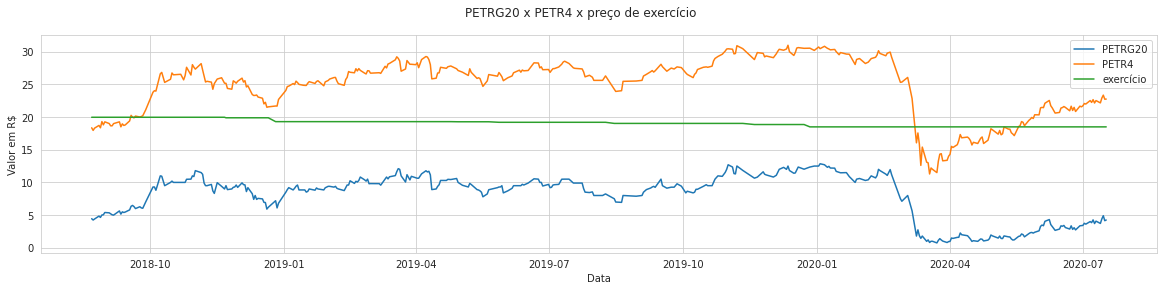

In [16]:
#@title Plot dos dados juntos
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('PETRG20 x PETR4 x preço de exercício')
ax.plot(data.loc[(data['codigo'] == 'PETRG20') & (data['data_vencimento'] == '2020-07-20'), 'preco_opcao'], label='PETRG20')
ax.plot(data.loc[(data['codigo'] == 'PETRG20') & (data['data_vencimento'] == '2020-07-20'), 'preco_ativo'], label='PETR4')
ax.plot(data.loc[(data['codigo'] == 'PETRG20') & (data['data_vencimento'] == '2020-07-20'), 'preco_exercicio'], label='exercício')
ax.set_ylabel('Valor em R$')
ax.set_xlabel('Data')
ax.legend()
plt.show()

# Black-Scholes

O cálculo fórmula de Black-Scholes de uma opção de compra é dado pela equação $C(t, T) = S(t)N(d_{1}) - Ke^{-r(T-t))}N(d_{2})$ e venda $P(t, T) = Ke^{-r(T-t))}N(-d_{2}) - S(t)N(-d_{1})$, onde $d_{1} = \frac{\ln\bigg({\frac{S(t)}{K}}\bigg)+\bigg(r+\frac{\sigma^{2}}{2}\bigg)(T-t)}{\sigma\sqrt{T-t}}$ e $d_{2} = \frac{\ln\bigg({\frac{S(t)}{K}}\bigg)+\bigg(r-\frac{\sigma^{2}}{2}\bigg)(T-t)}{\sigma\sqrt{T-t}}$.

In [17]:
#@title Formula
from scipy.stats import norm

# Auxiliary function for d_one risk-adjusted probability
def d11(S, X, T, r, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))

# Auxiliary function for d_two risk-adjusted probability
def d21(d1, T, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return d1 - sigma * np.sqrt(T)

# Definition of the Black-Scholes delta function
def bs_delta(S, X, T, r, sigma, option_type):
    """Compute the delta of the Black-Scholes option pricing formula.

    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'

    Returns: a numpy.float_ representing the delta value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    if option_type == 'OPÇÕES DE COMPRA':
        return norm.cdf(d11(S, X, T, r, sigma))
    elif option_type == 'OPÇÕES DE VENDA':
        return norm.cdf(-d11(S, X, T, r, sigma))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

# Definition of the Black-Scholes European option pricing formula
def black_scholes(S, X, T, r, sigma, option_type):
    """Price a European option using the Black-Scholes option pricing formula.

    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'

    Returns: a numpy.float_ representing the option value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    d_one = d11(S, X, T, r, sigma)
    d_two = d21(d_one, T, sigma)
    if option_type == 'OPÇÕES DE COMPRA':
        return S * norm.cdf(d_one) - np.exp(-r * T) * X * norm.cdf(d_two)
    elif option_type == 'OPÇÕES DE VENDA':
        return -(S * norm.cdf(-d_one) - np.exp(-r * T) * X * norm.cdf(-d_two))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

def bs_pandas(row):
    value = black_scholes(
        row['preco_ativo'],
        row['preco_exercicio'],
        row['T'],
        row['taxa_juros'],
        row['volatilidade'],
        row['mercado']
    )
    return round(value, 2)

def delta_pandas(row):
    value = bs_delta(
        row['preco_ativo'],
        row['preco_exercicio'],
        row['T'],
        row['taxa_juros'],
        row['volatilidade'],
        row['mercado']
    )
    return int(round(value * 100, 0))

# Aplicar as funções
data['black_scholes'] = data.apply(bs_pandas, axis=1)
data['delta_black_scholes'] = data.apply(delta_pandas, axis=1)
data.head()

,codigo,mercado,preco_opcao,preco_exercicio,data_vencimento,T,preco_ativo,volatilidade,taxa_juros,black_scholes,delta_black_scholes
2015-01-05,PETRM17,OPÇÕES DE VENDA,8.18,16.91,2015-01-19,0.039683,8.61,0.771953,0.1157,8.22,100
2015-01-05,PETRM28,OPÇÕES DE VENDA,0.36,8.41,2015-01-19,0.039683,8.61,0.771953,0.1157,0.41,40
2015-01-05,PETRM2,OPÇÕES DE VENDA,0.02,4.91,2015-01-19,0.039683,8.61,0.771953,0.1157,0.00,0
2015-01-05,PETRM23,OPÇÕES DE VENDA,0.79,9.21,2015-01-19,0.039683,8.61,0.771953,0.1157,0.87,63
2015-01-05,PETRM25,OPÇÕES DE VENDA,1.13,9.61,2015-01-19,0.039683,8.61,0.771953,0.1157,1.16,73


# Dividindo os dados entre treino, teste e validação

O periodo dos dados é composto de janeiro de 2015 até novembro de 2020. Assim, os dados de treino e teste pertencem ao periodo de janeiro de 2015 até dezembro de 2019, com uma divisão de 70% treino e 30% teste e os dados de validação pertecem ao periodo de janeiro de 2020 até março de 2020.

Para a divisão entre treino e teste, foi utilizada a seguinte métodologia:

- Os dados foram divididos considerando a data de vencimento da opção
- Após selecionada as opções dentro do mesmo vencimento, a divisão entre treino e teste foi feito da maneira aleatória, considerando a divisão 70/30.

In [40]:
#@title Treino, teste e validação
# Definir os dados de validaçnao
val = data[data['data_vencimento'] > '2020-01-01']
data = data[data['data_vencimento'] < '2020-01-01']

# Define train size dataframe percentage
train_size = .70

# Get list with unique expire date
expire_list = data['data_vencimento'].sort_values().unique()

# Create stratify column
data['base'] = ''

# Loop over the expire list 
for date in expire_list:

    # Get options from expire date
    option_list = data.loc[data['data_vencimento'] == date, 'codigo'].unique()

    # Calculate the size of ta
    size = int(option_list.shape[0] * train_size)

    # Generate random list of integers
    random_list = np.random.choice(range(option_list.shape[0]), size, replace=False)

    # Subset options randomly between train and test
    option_train = option_list[random_list]
    option_test = np.delete(option_list, random_list, None)

    data.loc[(data['data_vencimento'] == date) & (data['codigo'].isin(option_train)), 'base'] = 'treino'
    data.loc[(data['data_vencimento'] == date) & (data['codigo'].isin(option_test)), 'base'] = 'teste'

# Save to file

Os dados estão salvos dentro do meu Google Drive, porém estão disponíveis dentro do [Github](https://github.com/fernandofsilva/LSTM_Option_Pricing/tree/main/data) do projeto.

In [47]:
#@title Salvar Csv
# Salvar arquivos para Csv's
data.to_csv(f'/content/drive/My Drive/Mestrado/data/dados_treino_teste.csv.gz', index=False, compression='gzip')
val.to_csv(f'/content/drive/My Drive/Mestrado/data/dados_validacao.csv.gz', index=False, compression='gzip')